In [18]:
# only run once and the restart the kernel 
from numba import cuda
devices = cuda.get_current_device()
devices.reset()

In [1]:
import time
import os
import gc 
import h5py
import json

import numpy as np


import matplotlib.pyplot as plt 

from scipy import ndimage
from sklearn.utils import shuffle

from preProcessingUtils import *

### Data Reading 

In [2]:
# Reading the train data 
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Data_150_150_150_Clip_Norm.hdf5', 'r')
hf.keys
train_roi = np.array(hf.get('roi'))
train_notRoi = np.array(hf.get('notRoi'))
val_roi = np.array(hf.get('val_roi'))
val_notRoi = np.array(hf.get('val_notRoi'))
test_roi = np.array(hf.get('test_roi'))
test_notRoi = np.array(hf.get('test_notRoi'))



In [3]:
# Reading the train data 
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Label_150_150_150_Clip_Norm.hdf5', 'r')
hf.keys
train_roi_label = np.array(hf.get('roi'))
train_notRoi_label = np.array(hf.get('notRoi'))
val_roi_label = np.array(hf.get('val_roi'))
val_notRoi_label = np.array(hf.get('val_notRoi'))
test_roi_label = np.array(hf.get('test_roi'))
test_notRoi_label = np.array(hf.get('test_notRoi'))


### Data Augmentation 

In [4]:
# Data Augmentation : 8 Set Possible
# 1. Original Data 
# 2,3,4,5 Rotate 45, 90, 180 
# 6, 7, 8 Flip 

# Data Augmentation needs to be done before converting it to binary 

In [4]:
aVol = train_roi[0, :, :, :, 0]

In [10]:
vol = norm8bit(aVol)
th_vol = vol < 55

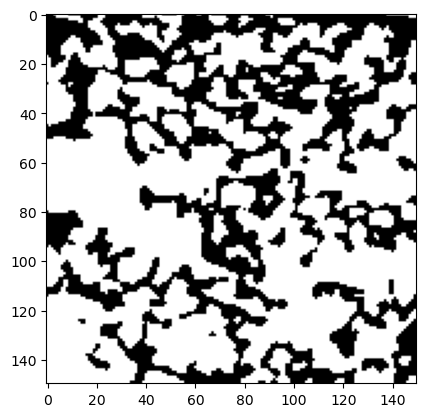

In [15]:
plt.imshow(th_vol[75, :, :], cmap='gray')

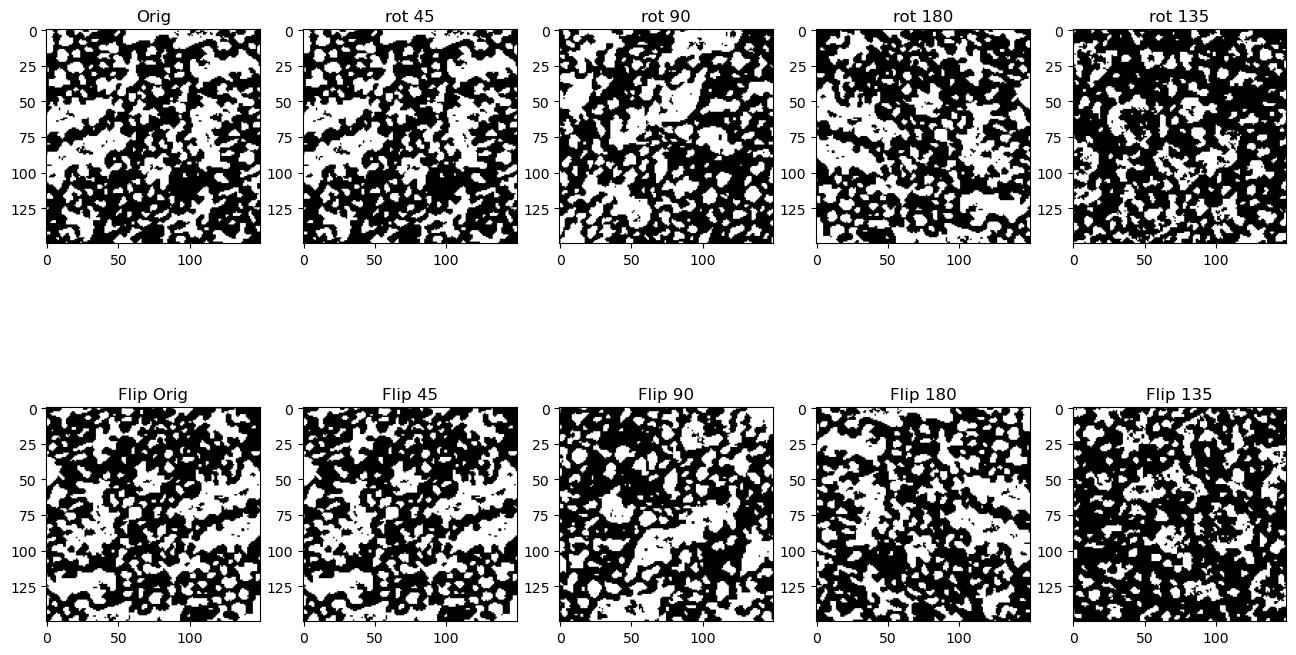

In [31]:
aVol = train_roi[15, :, :, :, 0]
vol = norm8bit(aVol)
th_vol = vol < 55
fig, ax = plt.subplots(2,5, figsize=(16,9))
ax[0,0].imshow(th_vol[75, :, :,], cmap='gray')
ax[0,0].set_title('Orig')

rot45 = ndimage.rotate(aVol, 45, reshape=False)
rot45 = norm8bit(rot45)
rot45 = rot45 < 55
ax[0,1].imshow(rot45[75, :, :], cmap='gray')
ax[0,1].set_title('rot 45')

rot90 = ndimage.rotate(aVol, 90, reshape=False)
rot90 = norm8bit(rot90)
rot90 = rot90 < 55
ax[0,2].imshow(rot90[75, :, :], cmap='gray')
ax[0,2].set_title('rot 90')

rot180 = ndimage.rotate(aVol, 180, reshape=False)
rot180 = norm8bit(rot180)
rot180 = rot180 < 55
ax[0,3].imshow(rot180[75, :, :], cmap='gray')
ax[0,3].set_title('rot 180')

rot135 = ndimage.rotate(aVol, 135, reshape=False)
rot135 = norm8bit(rot135)
rot135 = rot135 < 55
ax[0,4].imshow(rot135[75, :, :], cmap='gray')
ax[0,4].set_title('rot 135')

###########

flip = np.flip(th_vol)
ax[1,0].imshow(flip[75, :, :], cmap='gray')
ax[1,0].set_title('Flip Orig')


flip45 = np.flip(rot45)
ax[1,1].imshow(flip45[75, :, :], cmap='gray')
ax[1,1].set_title('Flip 45')

flip90 = np.flip(rot90)
ax[1,2].imshow(flip90[75, :, :], cmap='gray')
ax[1,2].set_title('Flip 90')

flip180 = np.flip(rot180)
ax[1,3].imshow(flip180[75, :, :], cmap='gray')
ax[1,3].set_title('Flip 180')

flip135 = np.flip(rot135)
ax[1,4].imshow(flip135[75, :, :], cmap='gray')
ax[1,4].set_title('Flip 135')

plt.show()

plt.close()

In [4]:
# Rotate formatted volume 
def rotateFormattedVol(arr, angle, reshape=False):
    result = np.zeros(shape=arr.shape, dtype='bool')
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = ndimage.rotate(vol, angle, reshape=reshape)
        vol[ vol < 0] = 0
        vol[ vol > 1] = 1
        vol = norm8bit(vol)
        th_vol = vol < 55
        result[i, :, :, :, 0] = th_vol 
        
    return result


# Flip formatted volume 
def flipFormattedVol(arr):
    result = np.zeros(shape=arr.shape, dtype=arr.dtype)
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = np.flip(vol)
        result[i, :, :, :, 0] = vol 
    
    return result

In [33]:
trainDataROI = np.concatenate( (rotateFormattedVol(train_roi, 0), flipFormattedVol(rotateFormattedVol(train_roi, 0)),
                                rotateFormattedVol(train_roi, 45), flipFormattedVol(rotateFormattedVol(train_roi, 45)),
                                rotateFormattedVol(train_roi, 90), flipFormattedVol(rotateFormattedVol(train_roi, 90)),
                                rotateFormattedVol(train_roi, 135), flipFormattedVol(rotateFormattedVol(train_roi, 135)), 
                                rotateFormattedVol(train_roi, 180), flipFormattedVol(rotateFormattedVol(train_roi, 180)), 
                                rotateFormattedVol(train_roi, 225), flipFormattedVol(rotateFormattedVol(train_roi, 225)),
                                rotateFormattedVol(train_roi, 270), flipFormattedVol(rotateFormattedVol(train_roi, 270)),
                                rotateFormattedVol(train_roi, 315), flipFormattedVol(rotateFormattedVol(train_roi, 315)) ),
                                axis=0)

train_label_ROI = np.concatenate((train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label), axis=0)

In [34]:
del train_roi
del train_roi_label

In [35]:
gc.collect()

50570

In [36]:
trainDatanotROI = np.concatenate( (rotateFormattedVol(train_notRoi, 0), flipFormattedVol(rotateFormattedVol(train_notRoi, 0)),  
                                   rotateFormattedVol(train_notRoi, 45), flipFormattedVol(rotateFormattedVol(train_notRoi, 45)),
                                   rotateFormattedVol(train_notRoi, 90), flipFormattedVol(rotateFormattedVol(train_notRoi, 90)),
                                   rotateFormattedVol(train_notRoi, 135), flipFormattedVol(rotateFormattedVol(train_notRoi, 135)),
                                   rotateFormattedVol(train_notRoi, 180), flipFormattedVol(rotateFormattedVol(train_notRoi, 180)),
                                   rotateFormattedVol(train_notRoi, 225), flipFormattedVol(rotateFormattedVol(train_notRoi, 225)),
                                   rotateFormattedVol(train_notRoi, 270), flipFormattedVol(rotateFormattedVol(train_notRoi, 270)), 
                                   rotateFormattedVol(train_notRoi, 315), flipFormattedVol(rotateFormattedVol(train_notRoi, 315)) ),
                                   axis=0)

train_label_notROI = np.concatenate((train_notRoi_label, train_notRoi_label,
                                     train_notRoi_label, train_notRoi_label,
                                     train_notRoi_label, train_notRoi_label, 
                                     train_notRoi_label, train_notRoi_label,
                                     train_notRoi_label, train_notRoi_label,
                                     train_notRoi_label, train_notRoi_label,
                                     train_notRoi_label, train_notRoi_label, 
                                     train_notRoi_label, train_notRoi_label ), axis=0)

In [37]:
del train_notRoi
del train_notRoi_label

In [38]:
gc.collect()

42

### Training Data preparation 

In [39]:
# trainFeatures = np.concatenate((train_roi, train_notRoi), axis=0)
# valFeatures = np.concatenate((val_roi, val_notRoi), axis=0)

trainFeatures = np.concatenate((trainDataROI, trainDatanotROI), axis=0)
valFeatures = np.concatenate((val_roi, val_notRoi), axis=0)

In [40]:
# del train_roi
# del train_notRoi

del trainDataROI
del trainDatanotROI

del val_roi
del val_notRoi



In [41]:
gc.collect()

63

In [42]:
# trainLabels = np.concatenate((train_roi_label, train_notRoi_label), axis=0)
# valLabels = np.concatenate((val_roi_label, val_notRoi_label), axis=0)

trainLabels = np.concatenate((train_label_ROI, train_label_notROI), axis=0)
valLabels = np.concatenate((val_roi_label, val_notRoi_label), axis=0)

In [43]:
# del train_roi_label
# del train_notRoi_label

del train_label_ROI
del train_label_notROI

del val_roi_label
del val_notRoi_label



In [44]:
gc.collect()

63

In [45]:
trainFeatures.shape

(13600, 150, 150, 150, 1)

In [46]:
trainFeatures.dtype

dtype('bool')

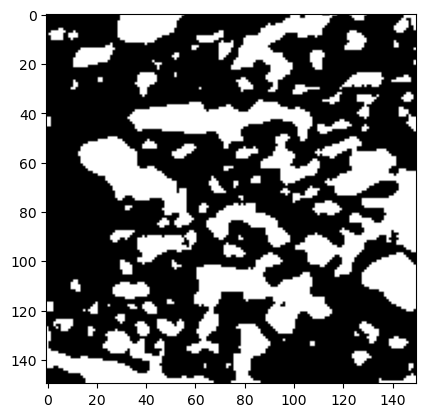

In [68]:
plt.imshow(X_val[10, 75, :, :, 0], cmap='gray')

In [48]:
from sklearn.utils import shuffle

In [49]:
X_train, y_train = shuffle(trainFeatures, trainLabels, random_state=101)
X_val, y_val = shuffle(valFeatures, valLabels, random_state=101)

In [50]:
del trainFeatures
del trainLabels
del valFeatures
del valLabels
gc.collect()

63

In [67]:
X_val = rotateFormattedVol(X_val, 0)

In [52]:
y_val[:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

In [5]:
import tensorflow as tf 
print(tf.__version__)

1.15.0


In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam

In [29]:
#del model 
#gc.collect()

229

In [34]:
#gpus = tf.config.experimental.list_physical_devices('GPU')

In [35]:
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [55]:
# Building a model 
input_shape=X_train.shape[1:]
model = models.Sequential()
# Conv Layers 
model.add(layers.Conv3D(8, (3, 3, 3), padding='same', activation ='relu', input_shape=input_shape, data_format='channels_last'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(3,3,3)))
model.add(layers.BatchNormalization())


# FC layer 
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate = 0.1))

model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(rate = 0.1))
model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 150, 150, 150, 8)  224       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 75, 75, 75, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 75, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 75, 75, 75, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 37, 37, 37, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 37, 16)    64        
_________________________________________

In [69]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

timeNow = time.strftime('%m%d%H%M')

csvFile = 'logs/train_150_clip_norm8bit_bool_Aug_all45ang_flip' + timeNow + '.csv'
csv_logger = CSVLogger(csvFile, append=True, separator=';')


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.001)

# saves model after every epoch or only best model yet if 'save_best_only=True'
model_checkpoint = ModelCheckpoint(('models/best_model_' + timeNow + '.hdf5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')


def print_summary(s):
    txt_file = csvFile.replace('.csv', '.txt')
    with open(txt_file,'a') as f:
        print(s, file=f)

model.summary(print_fn=print_summary)

# Training the model 
epochs = 50
batch_size = 16
hist = model.fit(X_train, y_train, batch_size=batch_size,
                 epochs=epochs, verbose=1, callbacks=[csv_logger, early_stopping, model_checkpoint],
                 validation_data=(X_val, y_val))

Train on 13600 samples, validate on 150 samples
Epoch 1/50
13584/13600 [============================>.] - ETA: 0s - loss: 0.3743 - acc: 0.8737
Epoch 00001: val_loss improved from inf to 0.44076, saving model to models/best_model_09271238.hdf5
13600/13600 [==============================] - 545s 40ms/sample - loss: 0.3741 - acc: 0.8737 - val_loss: 0.4408 - val_acc: 0.8533
Epoch 2/50
13584/13600 [============================>.] - ETA: 0s - loss: 0.2771 - acc: 0.9056
Epoch 00002: val_loss improved from 0.44076 to 0.34630, saving model to models/best_model_09271238.hdf5
13600/13600 [==============================] - 612s 45ms/sample - loss: 0.2770 - acc: 0.9057 - val_loss: 0.3463 - val_acc: 0.8467
Epoch 3/50
13584/13600 [============================>.] - ETA: 0s - loss: 0.2055 - acc: 0.9295
Epoch 00003: val_loss improved from 0.34630 to 0.29464, saving model to models/best_model_09271238.hdf5
13600/13600 [==============================] - 604s 44ms/sample - loss: 0.2053 - acc: 0.9296 - val_

In [31]:
gc.collect()

68

In [70]:
modelName = 'models/CNNfirstPass_' + timeNow + '.hdf5' # + time.strftime('%m%d%H%M') + '.hdf5'
model.save(modelName)

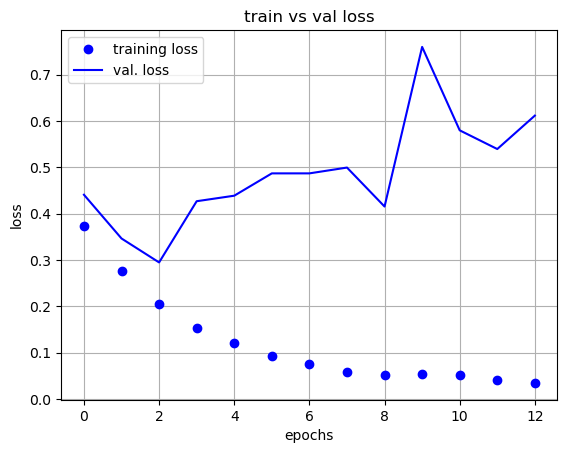

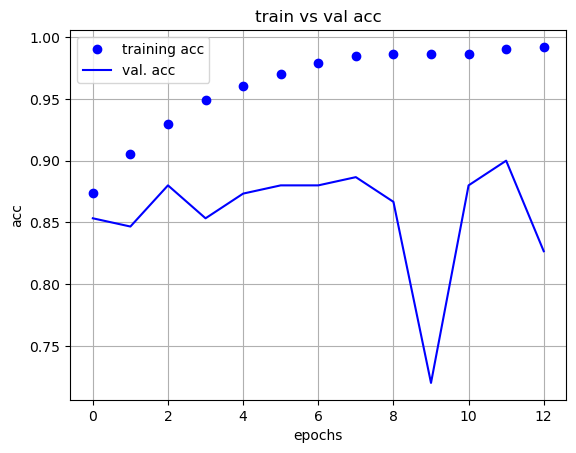

In [72]:
# Display trainig statistics 
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochsr = range(13)

plt.figure()
plt.plot(epochsr, loss, 'bo', label='training loss')
plt.plot(epochsr, val_loss, 'b', label='val. loss')
plt.title('train vs val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('ON')
plt.show()


plt.figure()
plt.plot(epochsr, acc, 'bo', label='training acc')
plt.plot(epochsr, val_acc, 'b', label='val. acc')
plt.title('train vs val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.grid('ON')
plt.show()

In [7]:
test_roi = rotateFormattedVol(test_roi, 0)
test_notRoi = rotateFormattedVol(test_notRoi, 0)

In [8]:
# Model evaluation 
X_test = np.concatenate((test_roi, test_notRoi), axis=0)
y_test = np.concatenate((test_roi_label, test_notRoi_label), axis=0)

In [9]:
from tensorflow.keras.models import load_model

In [16]:
model = load_model('models/CNNfirstPass_09261455.hdf5')

In [17]:
scores = model.evaluate(X_test, y_test)
print('Test %s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

94/94 [==============================] - 2s 20ms/sample - loss: 0.1849 - acc: 0.9574
Test acc: 95.74%


In [13]:
print(model.summary)

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002004C966408>>


In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
# from keras.callbacks import Callback

# # this would create a ',' separated csv file. 'append=True' writes to same file
# # Set value of 'append' as per your need
# csv_logger = CSVLogger('./outputs/training_'+'log_'+get_readable_ctime()+'.log', append=True)


# class LogMetrics(Callback):
#     def __init__(self, val1, val2):
#         self.param = param
#         self.val1 = val1
#         self.val2 = val2

#     def on_epoch_end(self, epoch, logs):
#         # epoch and logs are passed by Keras
#         logs["var_name1"] = self.val1
#         logs["var_name2"] = self.val2

# # ....
# # assume your code above that generates variables val1 and val2 that you want to store in csv
# # 'monitor' tells what metric to monitor to determine if training should be stopped early
# # 'min_delta' says how much change is the 'monitor' should be considered as a improvement in training.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#         patience=40, min_delta=0.0001)
# # saves model after every epoch or only best model yet if 'save_best_only=True'
# mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#         "best_model.h5"), monitor='val_loss', verbose=1, 
#         save_best_only=True, save_weights_only=False, mode='min', period=1)

# history = model.fit(x_t,y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE, 
#               shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
#               trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, LogMetrics(val1, val2), csv_logger])